# **Tugas 4**

In [1]:
# nama : yusril aminuddin
# nim : 201910370311366
# kelas : cbir sela 2023
# dosen pengampuh : bapak yufis azhar, S.Kom., M.Kom.
# penugasan : keempat

In [2]:
# ============
# INSTRUCTIONS
# ============
# Berdasarkan Tugas 3 yang Anda kerjakan sebelumnya, buatlah sebuah sistem image retrieval dengan deskripsi sebagai berikut:
# - User bisa memasukkan sebuah image query
# - Sistem akan mengeluarkan 5 image dengan jarak terdekat dari image query
# - Sistem akan mengeluarkan nilai precision, recall, dan F1 Score dari hasil retrieve tersebut.
# Buat source codenya di google colab, dan share url nya secara publik. Kemudian submit ke tugas ini.

In [3]:
# import library yang dibutuhkan
from google.colab import drive
import os
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from sklearn.decomposition import PCA
from scipy.spatial import distance
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import precision_score, recall_score, f1_score

In [4]:
# mount GDrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# initial variable for dataset folder and resized folder
originalDataset = "/content/drive/MyDrive/Colab Notebooks/Sela 2023/CBIR/Tugas 4/dataset"
queryDataset = "/content/drive/MyDrive/Colab Notebooks/Sela 2023/CBIR/Tugas 4/query/"

In [6]:
# check total citra yang bisa di analisa
image_extensions = ['.jpg', '.png', '.jpeg']

# save to list image
dataset_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(originalDataset) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

# show len
print("Terdapat %d citra yang bisa di analisa" % len(dataset_images))

Terdapat 10 citra yang bisa di analisa


In [7]:
# init model VGG16
model = VGG16(weights='imagenet', include_top=True)

# menampilkan summary
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# init feature_extractor dari model VGG16
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

# menampilkan summary
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# list untuk menyimpan fetures hasil proses ekstraksi dari semua citra dataset yang didapat dari feature_extractor (VGG16)
dataset_features = []

# ekstrak setiap feature dari list dataset_images[]
for i, image_path in enumerate(dataset_images):

    print("Menganalisa citra %d / %d." % (i, len(dataset_images)))

    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    feat = feature_extractor.predict(x)[0]
    dataset_features.append(feat)

# show success
print("Selesai meng-ekstrak feature untuk %d citra" % len(dataset_images))

Menganalisa citra 0 / 10.
1/1 [==============================] - 3s 3s/step
Menganalisa citra 1 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 2 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 3 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 4 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 5 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 6 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 7 / 10.
1/1 [==============================] - 1s 1s/step
Menganalisa citra 8 / 10.
1/1 [==============================] - 2s 2s/step
Menganalisa citra 9 / 10.
1/1 [==============================] - 2s 2s/step
Selesai meng-ekstrak feature untuk 10 citra


In [10]:
# init final_dataset_features as array from list before
final_dataset_features = np.array(dataset_features)

# pca and n_components = len of image_dataset
pca = PCA(n_components=10)

# fitting final_dataset_features
pca.fit(final_dataset_features)

PCA(n_components=10)

In [11]:
# transform dari final_dataset_features ke pca_features
pca_features = pca.transform(final_dataset_features)

In [12]:
# membuat fungsi get_concatenated_images untuk penggabungan citra
def get_concatenated_images(indexes, closest_test_height):
    closest_images = []
    for idx in indexes:
        img = image.load_img(dataset_images[idx])
        img = img.resize((int(img.width * closest_test_height / img.height), closest_test_height))
        closest_images.append(img)
    concatenated_image = np.concatenate([np.asarray(t) for t in closest_images], axis=1)
    return concatenated_image

Text(0.5, 1.0, 'test hasil akhir berikut penggabungan citra')

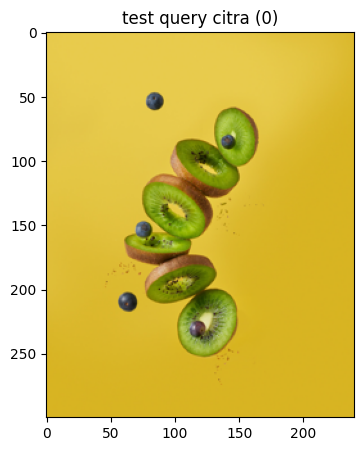

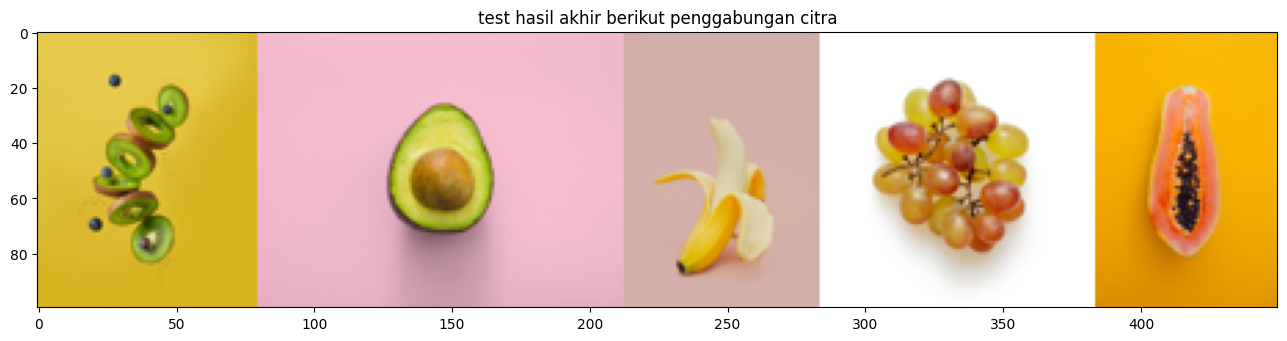

In [13]:
# test cbir dan menampilkannya (hasil query dan hasil penggabungan gambar) : index ke-0
test_query_image_idx = 0

# get image from get_concatenated_images func as single value of array
test_query_image = get_concatenated_images([test_query_image_idx], 300)

# init query yang serupa untuk mencari distance.euclidean
test_distances = [ distance.euclidean(pca_features[test_query_image_idx], feat) for feat in pca_features ]

# 5 terdekat
test_closest_idx = sorted(range(len(test_distances)), key=lambda k: test_distances[k])[0:5]

# hasil penggabungan citra dari hasil 5 terdekat
test_result_image = get_concatenated_images(test_closest_idx, 100)

plt.figure(figsize = (5, 5))
plt.imshow(test_query_image)
plt.title("test query citra (%d)" % test_query_image_idx)

plt.figure(figsize = (16, 12))
plt.imshow(test_result_image)
plt.title("test hasil akhir berikut penggabungan citra")

In [14]:
# change directory to query dataset and show current path
os.chdir(queryDataset)
%pwd

'/content/drive/MyDrive/Colab Notebooks/Sela 2023/CBIR/Tugas 4/query'

Saving query.jpg to query.jpg
1/1 [==============================] - 1s 609ms/step


Text(0.5, 1.0, 'hasil akhir berikut penggabungan citra')

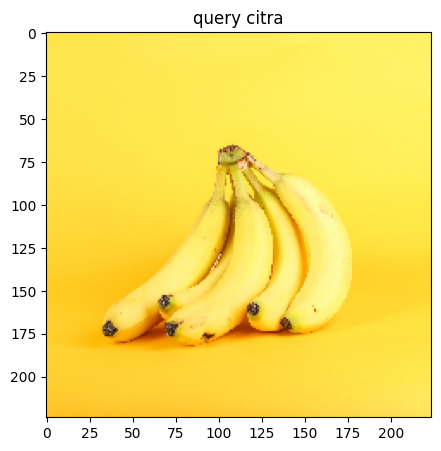

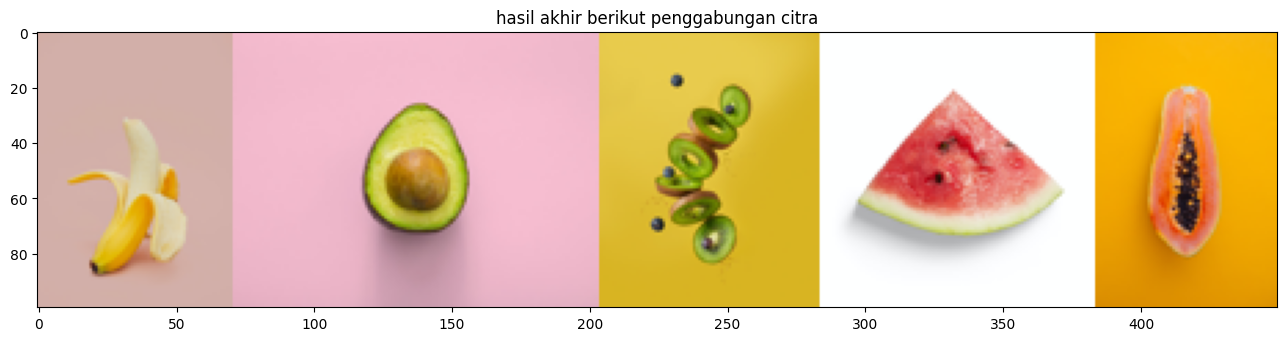

In [15]:
# make sure resized folder is empty
%rm -rf *

# unggah citra
uploaded = files.upload()
for fn in uploaded.keys():
  path = fn

# query_image sebagai citra dan query_image_idx sebagai index
query_image = image.load_img(path, target_size=model.input_shape[1:3])
query_image_idx = image.img_to_array(query_image)
query_image_idx = np.expand_dims(query_image_idx, axis=0)
query_image_idx = preprocess_input(query_image_idx)

# proses feature ekstraksi dan pca
query_features = feature_extractor.predict(query_image_idx)
query_pca_features = pca.transform(query_features)[0]

# get jarak terdekat
query_distances = [ distance.euclidean(query_pca_features, feat) for feat in pca_features ]
query_closest_idx = sorted(range(len(query_distances)), key=lambda k: query_distances[k])[0:5]  # grab 5 closest

# hasil image dari proses akhir yang digabungkan
query_result_image = get_concatenated_images(query_closest_idx, 100)

plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query citra")

plt.figure(figsize = (16,12))
plt.imshow(query_result_image)
plt.title("hasil akhir berikut penggabungan citra")

In [16]:
# treshold value sebagai minimal patokan distance
threshold = 50

# classify data points based on the threshold
classified_as_positive = [1 if dist <= threshold else 0 for dist in query_distances]

# true labels as 1 value all
true_labels = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# calculate precision, recall, and F1 Score
precision = precision_score(true_labels, classified_as_positive)
recall = recall_score(true_labels, classified_as_positive)
f1 = f1_score(true_labels, classified_as_positive)

# print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 1.00
Recall: 0.10
F1 Score: 0.18
